**EXP2 Predicitng Missing Cell-Types from Bulks using CIBERSORTx Residual**

*This file includes EXP2 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

Code based on:
1. https://github.com/greenelab/sc_bulk_ood/blob/main/sc_preprocessing/0_qc_notebooks/scanpy_analysis_pbmc6k.ipynb
2. https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

**Data Details:**

Data downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE176171
Original paper: https://pubmed.ncbi.nlm.nih.gov/35296864/ PMID: 35296864

Source name	omental adipose tissue
Organism	Homo sapiens
Characteristics	tissue: white adipose tissue
Sex: female
age: 29y
bmi: 49.3
surgery: VSG

**Experimental Details:**

In [27]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import celltypist
from celltypist import models

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from scipy.spatial.distance import euclidean
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import umap
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [28]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_snadp_EXP2"
pseudos_name = "MCT_snadp_EXP1"
#noise_type 
nt = "nonoise"
actual_path = os.getcwd()
path = f"{actual_path}/../data/"
aug_data_path = f"{actual_path}/../data/EXP2/"
data_path = f"{actual_path}/../data/EXP1/"
num_missing_cells = [0,1,2,3,4,8,12]
random_seed = 88
bulkprop_type = "random"
bulks_type = f"{bulkprop_type}prop_{nt}"

## **Reading and QCing the data:**

In [29]:
#as anndata object
adata_path = os.path.join(data_path, f"{pseudos_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
adata = sc.read_h5ad(adata_path)
Counter(adata.obs.cell_types)

Counter({'mesothelial cell': 26276,
         'fat cell': 24825,
         'macrophage': 13625,
         'preadipocyte': 26941,
         'endothelial cell': 11480,
         'endothelial cell of lymphatic vessel': 2339,
         'pericyte cell': 1165,
         'T cell': 3022,
         'smooth muscle cell': 2457,
         'B cell': 231,
         'dendritic cell': 679,
         'mast cell': 883,
         'monocyte': 709,
         'stromal cell of endometrium': 284,
         'immature NK T cell': 1073,
         'neutrophil': 77})

QC imported dataset:

In [30]:
#QC that it is not normalized
adata.X.max()

9832.0

         Falling back to preprocessing with `sc.pp.pca` and default params.


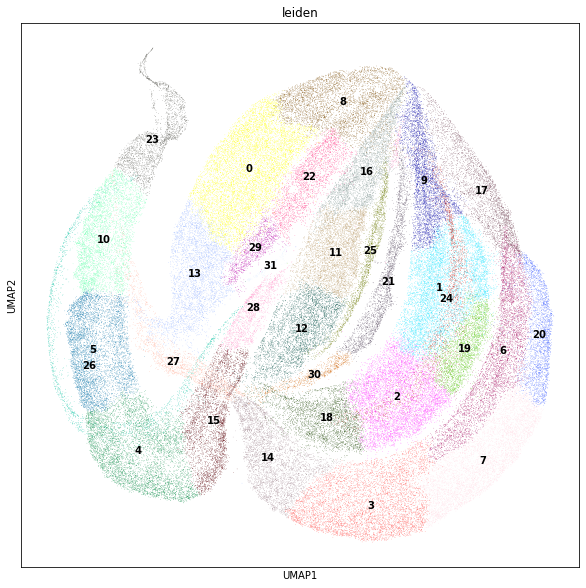

In [31]:
# lets use Leiden clustering
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.8)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color='leiden', legend_loc='on data')

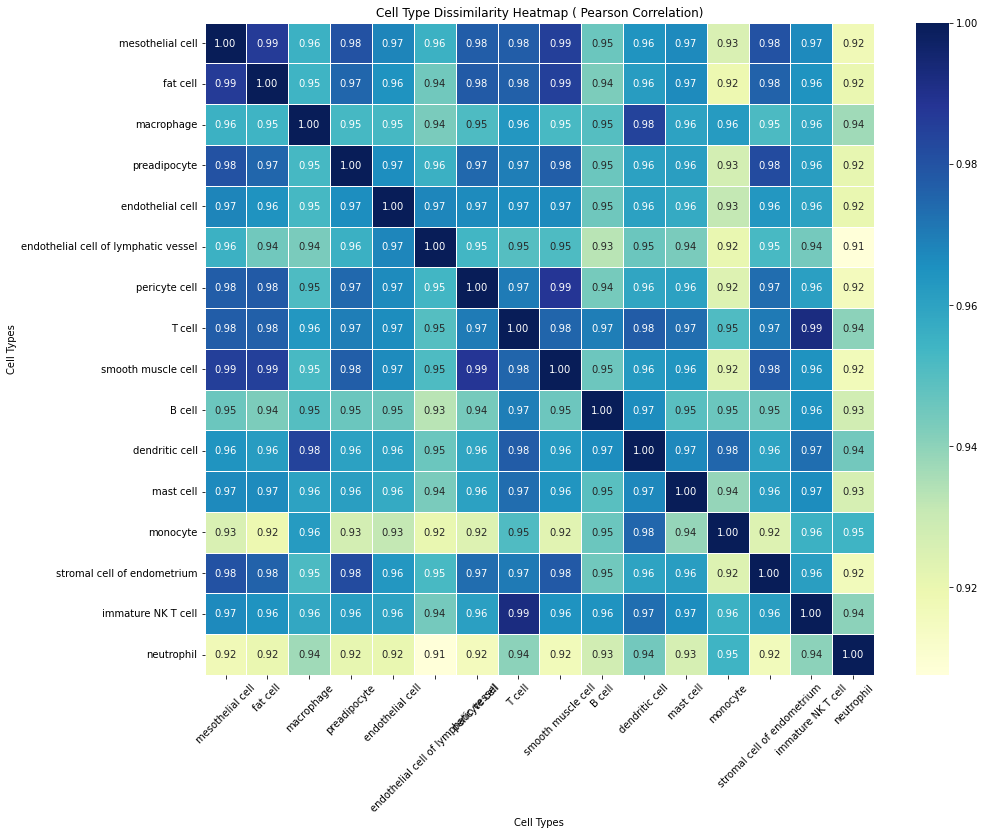

In [32]:
# Define the number of samples for resampling
num_samples = 10000

# Making cell type reference without scaling
cell_types = adata.obs["cell_types"].unique()
gene_ids = adata.var["gene_ids"]
ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

for cell_type in cell_types:
    cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
    cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    ref_raw[cell_type] = sum_over_genes.values

# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a heatmap to visualize the similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.xticks(rotation=45)
plt.show()

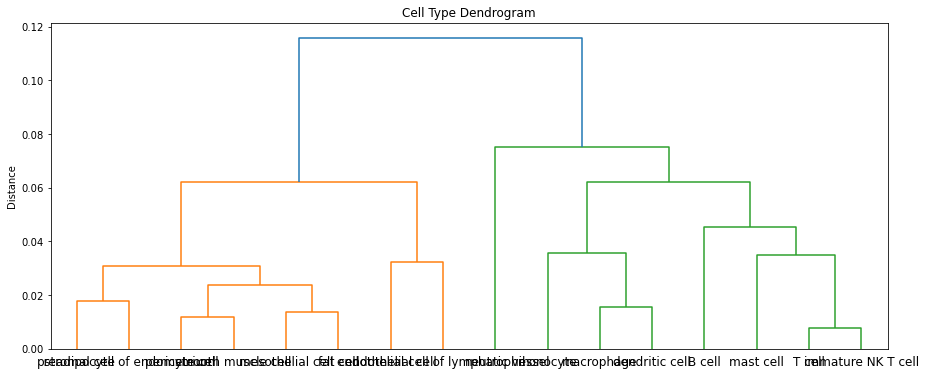

In [33]:
# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =1 - correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a dendrogram to visualize hierarchical clustering
linkage_matrix = linkage(squareform(cell_types_similarity), method='ward')
plt.figure(figsize=(35, 6))
dendrogram(linkage_matrix, labels=cell_types, orientation='top')
plt.title("Cell Type Dendrogram")
plt.ylabel("Distance")
plt.show()

In [34]:
#check cell types in untransformed data
sn_adata = adata.copy()
sn_adata.obs["scpred_CellType"] = sn_adata.obs["cell_types"]
Counter(sn_adata.obs["scpred_CellType"])

Counter({'mesothelial cell': 26276,
         'fat cell': 24825,
         'macrophage': 13625,
         'preadipocyte': 26941,
         'endothelial cell': 11480,
         'endothelial cell of lymphatic vessel': 2339,
         'pericyte cell': 1165,
         'T cell': 3022,
         'smooth muscle cell': 2457,
         'B cell': 231,
         'dendritic cell': 679,
         'mast cell': 883,
         'monocyte': 709,
         'stromal cell of endometrium': 284,
         'immature NK T cell': 1073,
         'neutrophil': 77})

## Defining Cell Types to delete from Reference

In [35]:
cells_to_miss = sn_sc_preprocess.select_cells_missing(sn_adata, num_missing_cells, random_seed)
cells_to_miss

{0: [],
 1: [6],
 2: [12, 6],
 3: [12, 6, 15],
 4: [9, 12, 6, 15],
 8: [1, 5, 6, 9, 11, 12, 14, 15],
 12: [0, 1, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15]}

## **Importing and QCing Pseudobulks**

All Cells Included in Reference:

In [36]:
num_cell_type_specific = 50 * int(adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

1400

In [37]:
X_full, Y_full, gene_df, meta_df= sn_sc_preprocess.read_all_pseudobulk_files(data_path=data_path, noise_type= f"{nt}_", file_name = pseudos_name, num_bulks_training = num_bulks, num_files=10, random_selection = False)
X_full.index = meta_df.index
Y_full.index = meta_df.index

0
1
2
3
4
5
6
7
8
9


(8000, 2)
(8000, 2)


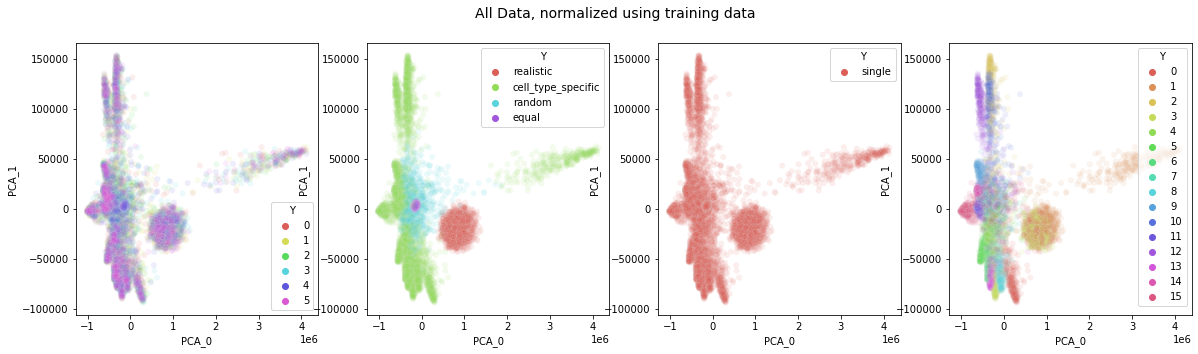

In [38]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_pca_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.104s...
[t-SNE] Computed neighbors for 8000 samples in 13.867s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 7054.811778
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.521347
[t-SNE] KL divergence after 500 iterations: 0.918567
(8000, 2)
(8000, 2)


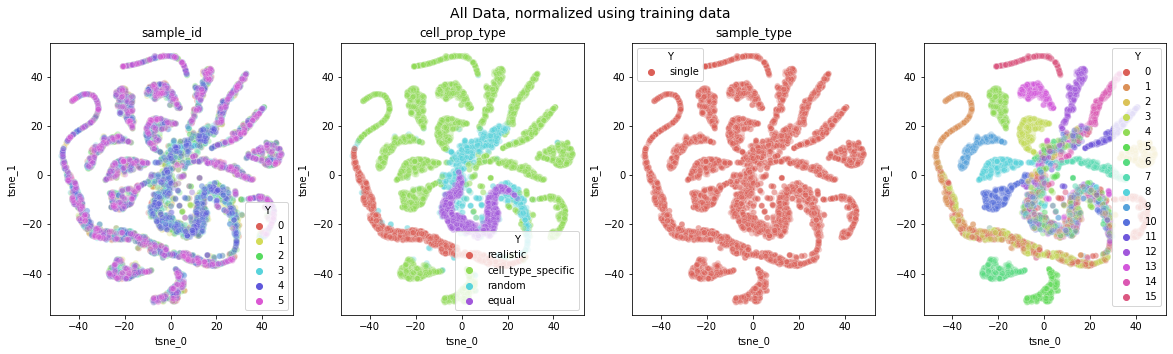

In [39]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_tsne_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"sample_id")
vp.plot_tsne(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"cell_prop_type")
vp.plot_tsne(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"sample_type")
vp.plot_tsne(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)
fig.show()

In [40]:
#cut to only the random samples
idx_interest = np.where(meta_df.cell_prop_type == "random")[0]
pseudos_df = X_full.iloc[idx_interest]
prop_df = Y_full.iloc[idx_interest]
pseudos_df.index = range(0,len(pseudos_df))
prop_df.index = pseudos_df.index
meta_df.index = meta_df.index
pseudos_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,47.0,131.0,13.0,2701.0,128.0,48.0,356.0,14.0,134.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1,69.0,136.0,7.0,4209.0,271.0,40.0,637.0,17.0,227.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0
2,65.0,137.0,1.0,4548.0,276.0,25.0,435.0,17.0,249.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,78.0,172.0,16.0,3758.0,146.0,51.0,445.0,16.0,196.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,3.0,0.0
4,42.0,135.0,9.0,3463.0,139.0,42.0,469.0,12.0,179.0,2.0,...,2.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,50.0,209.0,2.0,3461.0,239.0,28.0,339.0,8.0,175.0,4.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0
1996,39.0,101.0,5.0,2376.0,161.0,41.0,203.0,10.0,97.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
1997,58.0,147.0,14.0,4605.0,349.0,45.0,365.0,2.0,159.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1998,70.0,154.0,29.0,3873.0,241.0,36.0,458.0,12.0,205.0,2.0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0


In [41]:
#adding gene ids as columns
pseudos_df.columns = gene_ids.index
pseudos_df

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,47.0,131.0,13.0,2701.0,128.0,48.0,356.0,14.0,134.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1,69.0,136.0,7.0,4209.0,271.0,40.0,637.0,17.0,227.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0
2,65.0,137.0,1.0,4548.0,276.0,25.0,435.0,17.0,249.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,78.0,172.0,16.0,3758.0,146.0,51.0,445.0,16.0,196.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,3.0,0.0
4,42.0,135.0,9.0,3463.0,139.0,42.0,469.0,12.0,179.0,2.0,...,2.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,50.0,209.0,2.0,3461.0,239.0,28.0,339.0,8.0,175.0,4.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0
1996,39.0,101.0,5.0,2376.0,161.0,41.0,203.0,10.0,97.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
1997,58.0,147.0,14.0,4605.0,349.0,45.0,365.0,2.0,159.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1998,70.0,154.0,29.0,3873.0,241.0,36.0,458.0,12.0,205.0,2.0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0


In [42]:
#cutting to 1000 pseudos w/ random seed
random.seed(seed=random_seed)
idx_to_keep = np.random.choice(pseudos_df.index, 1000, replace=False)
#cutting both props and pseudos
pseudos_df = pseudos_df.iloc[idx_to_keep]
prop_df = prop_df.iloc[idx_to_keep]
pseudos_df

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
1059,54.0,166.0,6.0,3148.0,130.0,36.0,406.0,14.0,172.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0
929,64.0,146.0,4.0,3444.0,192.0,42.0,397.0,13.0,177.0,1.0,...,2.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
1506,43.0,129.0,12.0,3775.0,262.0,39.0,510.0,8.0,147.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
237,68.0,170.0,3.0,5836.0,445.0,20.0,361.0,9.0,154.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1371,51.0,140.0,7.0,3764.0,131.0,40.0,382.0,19.0,205.0,0.0,...,1.0,0.0,0.0,2.0,3.0,0.0,0.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,51.0,170.0,7.0,3449.0,162.0,48.0,383.0,12.0,208.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1132,54.0,116.0,5.0,6888.0,254.0,38.0,556.0,14.0,301.0,1.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1998,70.0,154.0,29.0,3873.0,241.0,36.0,458.0,12.0,205.0,2.0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
1988,49.0,136.0,8.0,3047.0,279.0,40.0,370.0,11.0,124.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Putting together all reference expression and proportions.

Limiting Cell Type number for computation

In [ ]:
cell_order = prop_df.columns

In [43]:
#import anndata object
adata_path = os.path.join(data_path, f"{pseudos_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
adata = sc.read_h5ad(adata_path)

cell_types_to_limit = cell_order
#define the cell types to limit and the desired maximum number of cells
max_cells_per_type = 700

#dreate a mask to identify cells from the cell types to limit
mask_to_limit = adata.obs["cell_types"].isin(cell_types_to_limit)

#create a mask for the remaining cell types
mask_remaining = ~mask_to_limit

#initialize a dictionary to keep track of removed cells per cell type
removed_cells_count = {cell_type: 0 for cell_type in cell_types_to_limit}

#initialize arrays to store new observations and filtered indices
new_obs = []
filtered_indices = []

#iterate through each cell in the original sn_adata object
for cell_idx, cell_type in enumerate(adata.obs["cell_types"]):
    if cell_type in cell_types_to_limit:
        removed_count = removed_cells_count.get(cell_type, 0)
        if removed_count < max_cells_per_type:
            removed_cells_count[cell_type] = removed_count + 1
            filtered_indices.append(cell_idx)

#create a new AnnData object with the filtered cells
filtered_sn_adata = sc.AnnData(
    X=adata.X[filtered_indices],
    obs=adata.obs.iloc[filtered_indices],
    var=adata.var
)

#cppend the remaining cell types to the filtered sn_adata object
filtered_sn_adata = filtered_sn_adata.concatenate(
    adata[mask_remaining],
    join="outer"
)
#QC
print(Counter(filtered_sn_adata.obs.cell_types))
#save as anndata object
adata_path = os.path.join(data_path, f"{pseudos_name}_adata_limitedcells_notlog.h5ad")
adata_path = Path(adata_path)
filtered_sn_adata.write_h5ad(adata_path)

... storing 'cell_types' as categorical


Counter({'mast cell': 883, 'monocyte': 709, 'dendritic cell': 679, 'mesothelial cell': 550, 'fat cell': 550, 'macrophage': 550, 'preadipocyte': 550, 'endothelial cell': 550, 'endothelial cell of lymphatic vessel': 550, 'pericyte cell': 550, 'T cell': 550, 'smooth muscle cell': 550, 'immature NK T cell': 550, 'stromal cell of endometrium': 284, 'B cell': 231, 'neutrophil': 77})


In [44]:
#using the filtered adata with less cells
sn_adata = filtered_sn_adata

In [45]:
# initializing dicitonaries of proportions and cell references.
all_refs = dict()
all_prop_refs_rebalanced = dict()
all_prop_refs = dict()

In [46]:
print(Counter(sn_adata.obs.cell_types))
#to dense matrix and saving into path
dense_matrix = sn_adata.X.todense()
dense_df = pd.DataFrame(dense_matrix, columns = sn_adata.var['gene_ids'])
dense_df.insert(loc=0, column='cell_types', value=sn_adata.obs["cell_types"].to_list())
#save file
dense_df.index = dense_df.index +  1
#qc
sig_df_sn = dense_df
print(sig_df_sn.shape)
all_refs[0] = sig_df_sn

Counter({'mast cell': 883, 'monocyte': 709, 'dendritic cell': 679, 'mesothelial cell': 550, 'fat cell': 550, 'macrophage': 550, 'preadipocyte': 550, 'endothelial cell': 550, 'endothelial cell of lymphatic vessel': 550, 'pericyte cell': 550, 'T cell': 550, 'smooth muscle cell': 550, 'immature NK T cell': 550, 'stromal cell of endometrium': 284, 'B cell': 231, 'neutrophil': 77})
(8363, 28243)


In [47]:
#assigning the rest in a loop
for num in num_missing_cells:
    if num != 0:
        #dropping cell types missing from proportions
        all_prop_refs[num] = prop_df.drop(prop_df.columns[cells_to_miss[num]], axis=1) 
        all_prop_refs_rebalanced[num] = all_prop_refs[num]
        for idx,sample in all_prop_refs_rebalanced[num].iterrows():
            tot = np.sum(sample) #making them equal 1
            sample = sample / tot
    else: 
        all_prop_refs[num] = prop_df  
        all_prop_refs_rebalanced[num] = prop_df 
    #allign indexes with R
    all_prop_refs[num].index = all_prop_refs[num].index + 1
    all_prop_refs_rebalanced[num].index = all_prop_refs_rebalanced[num].index + 1
    #and save files
    #rebalances proportions
    sc_profile_file = os.path.join(aug_data_path, f"{res_name}_{num}missing_{bulks_type}_proprebal.csv")
    sc_profile_path = Path(sc_profile_file)
    all_prop_refs_rebalanced[num].to_csv(sc_profile_path,  index=False)
    #and not rebalances
    sc_profile_file = os.path.join(aug_data_path, f"{res_name}_{num}missing_{bulks_type}_prop.csv")
    sc_profile_path = Path(sc_profile_file)
    all_prop_refs[num].to_csv(sc_profile_path, index=False)


In [48]:
#to dense matrix and copying into dict entry

#with no cell missing is just the anndata object as is
#import anndata object
adata_path = os.path.join(data_path, f"{pseudos_name}_adata_limitedcells_notlog.h5ad")
adata_path = Path(adata_path)
adata = sc.read_h5ad(adata_path)

dense_matrix = adata.X.todense()
dense_mat = dict()    
cell_states = dict()
cols = ["cell_id", "cell_type", "cell_subtype", "tumor_state"] #for cell state
for num in num_missing_cells:
    dense_mat[num] = dense_matrix.copy()
    #opening anndata
    #saving into path
    dense_df = pd.DataFrame(dense_mat[num], columns = adata.var['gene_ids'].index)
    dense_df["cell_types"] = adata.obs["cell_types"].values
    #drop cell types from reference accordingly:
    for cell in cell_types[cells_to_miss[num]]:
        print(cell)
        dense_df = dense_df.drop(dense_df[dense_df["cell_types"] == cell].index)
    #save file
    dense_df.index = dense_df["cell_types"]
    dense_df.pop("cell_types")
    all_refs[num] = dense_df
    #qc
    print(dense_df.shape)

(8363, 28242)
pericyte cell
(7813, 28242)
monocyte
pericyte cell
(7104, 28242)
monocyte
pericyte cell
neutrophil
(7027, 28242)
B cell
monocyte
pericyte cell
neutrophil
(6796, 28242)
fat cell
endothelial cell of lymphatic vessel
pericyte cell
B cell
mast cell
monocyte
immature NK T cell
neutrophil
(4263, 28242)
mesothelial cell
fat cell
endothelial cell
endothelial cell of lymphatic vessel
pericyte cell
T cell
B cell
mast cell
monocyte
stromal cell of endometrium
immature NK T cell
neutrophil
(2329, 28242)


In [49]:
mix = dict()
sig = dict()
for num in num_missing_cells:
    reference = all_refs[num]
    bt = bulks_type
    #details
    num_str = str(num)  
    exp_id = str(res_name)
    #and create files for EXP2 BP
    mix[num], sig[num] = sn_sc_preprocess.write_cibersortx_files(bp_path = aug_data_path, out_file_id = exp_id, 
                                         sig_df = reference,  X_train = pseudos_df, num_str = num_str, bulks_type= bt)
mix[0]

In [52]:
# mix[0] contains all pseudobulks
sc_profile_file = os.path.join(aug_data_path, f"{exp_id}_{bulks_type}_mixture.txt")
sc_profile_path = Path(sc_profile_file)
mix[0].to_csv(sc_profile_path, sep = '\t', index= True)